In [ ]:
! pip install scanpy
! pip install pydiffmap
! pip install pytorch_lightning
! pip install lassonet
! pip install smashpy

     |████████████████████████████████| 2.0 MB 25.5 MB/s 
     |████████████████████████████████| 11.2 MB 46.7 MB/s 
     |████████████████████████████████| 88 kB 6.2 MB/s 
     |████████████████████████████████| 96 kB 1.9 MB/s 
     |████████████████████████████████| 930 kB 21.5 MB/s 
     |████████████████████████████████| 1.1 MB 37.3 MB/s 
     |████████████████████████████████| 63 kB 840 kB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=b6263e4d1ff0d4d39065a9bc6bc83b450c75661a9cce9fed354c23551cbf2af0
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=87a58d8a400f148125a482408ffb943236b6db98061290a73ddf9e1eef997d28
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
  Created wheel for session-info: filename=session_info-1.0.0-py3-n

     |████████████████████████████████| 584 kB 26.2 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 
     |████████████████████████████████| 409 kB 50.6 MB/s 
     |████████████████████████████████| 136 kB 57.1 MB/s 
     |████████████████████████████████| 1.1 MB 49.6 MB/s 
     |████████████████████████████████| 144 kB 47.2 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 271 kB 55.8 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 454.3 MB 16 kB/s 
     |████████████████████████████████| 192.9 MB 77 kB/s 
     |████████████████████████████████| 564 kB 45.6 MB/s 
     |████████████████████████████████| 14.8 MB 53.1 MB/s 
     |████████████████████████████████| 462 kB 49.4 MB/s 
     |████████████████████████████████| 4.0 MB 40.3 MB/s 
     |████████████████████████████████| 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import math

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from torch import nn

from pydiffmap import diffusion_map, visualization

# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)

sys.path.append('/content/drive/MyDrive/High_D_Final_Project/HighD Final Project/src')

from markermap.utils import new_model_metrics, parse_adata
from markermap.utils import RandomBaseline, SmashPyWrapper
from markermap.utils import split_data_into_dataloaders, form_block


In [ ]:
def getSwissRoll():
    # set parameters
    length_phi = 15   #length of swiss roll in angular direction
    length_Z = 15     #length of swiss roll in z direction
    sigma = 0.1       #noise strength
    m = 10000         #number of samples

    # create dataset
    phi = length_phi*np.random.rand(m)
    xi = np.random.rand(m)
    Z = length_Z*np.random.rand(m)
    X = 1./6*(phi + sigma*xi)*np.sin(phi)
    Y = 1./6*(phi + sigma*xi)*np.cos(phi)

    swiss_roll = np.array([X, Y, Z]).transpose()

    # check that we have the right shape
    print(swiss_roll.shape)

    # initialize Diffusion map object.
    neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}
    n_evecs = 4

    mydmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs=n_evecs, k=100, epsilon=0.0156, alpha=1.0, neighbor_params=neighbor_params)
    # fit to data and return the diffusion map.
    mydmap.fit(swiss_roll)
    print(mydmap.epsilon_fitted)

    # plot the diffusion embeddings
    plot2d(mydmap.dmap, n_cols=n_evecs, colors=mydmap.dmap[:,0], show=False)

    # plot the data in the original dimensions
    plot3d(mydmap.data, n_cols=3, colors=mydmap.dmap[:,0], show=True)

    return swiss_roll


def plot2d(X, n_cols, skip_eigenvecs = {}, colors = None, show=True):
    assert n_cols <= X.shape[1]

    for i in range(n_cols):
        if i in skip_eigenvecs:
            continue

        for j in range(i+1, n_cols):
            if j in skip_eigenvecs:
                continue

            fig1, ax1 = plt.subplots()
            if colors is not None:
                ax1.scatter(X[:,i], X[:,j], c=colors, cmap='Spectral')
            else:
                ax1.scatter(X[:,i], X[:,j])

            # used for finding the eigenvalue outliers, prob a better way of doing this?
            # for k in range(X.shape[0]):
            #     ax1.annotate(k, (X[k,i], X[k,j]))

            ax1.set_xlabel(f'Eigenvec {i}')
            ax1.set_ylabel(f'Eigenvec {j}')

    plt.tight_layout()

    if show:
        plt.show()


def plot3d(X, n_cols, skip_eigenvecs = {}, colors = None, show=True):
    assert n_cols <= X.shape[1]

    for i in range(n_cols):
        if i in skip_eigenvecs:
            continue

        for j in range(i+1, n_cols):
            if j in skip_eigenvecs:
                continue

            for k in range(j+1, n_cols):
                if k in skip_eigenvecs:
                    continue

                fig1, ax1 = plt.subplots(subplot_kw={'projection':'3d'})
                if colors is not None:
                    ax1.scatter(X[:,i], X[:,j], X[:,k], c=colors, cmap='Spectral')
                else:
                    ax1.scatter(X[:,i], X[:,j], X[:,k])

                ax1.set_xlabel(f'Eigenvec {i}')
                ax1.set_ylabel(f'Eigenvec {j}')
                ax1.set_zlabel(f'Eigenvec {k}')

    plt.tight_layout()

    if show:
        plt.show()


def getZeiselData():
    adata = sc.read_h5ad('/content/drive/MyDrive/High_D_Final_Project/HighD Final Project/data/zeisel/Copy of Zeisel.h5ad')
    adata.obs['annotation'] = adata.obs['names0']
    X, y, encoder = parse_adata(adata)
    print(X.shape)

    # epsilon = 256 # this is what BGH finds
    epsilon = X.shape[1]/5
    k = 10

    return X, y, epsilon, k

def getCiteSeqData():
    adata = sc.read_h5ad('/content/drive/MyDrive/High_D_Final_Project/HighD Final Project/data/CITE-seq/Copy of CITEseq.h5ad')
    adata.obs['annotation'] = adata.obs['names']
    X, y, encoder = parse_adata(adata)

    # remove some outliers
    outliers = [1066, 779, 8458]
    X = np.delete(X, outliers, axis=0)
    y = np.delete(y, outliers)

    # epsilon = 64 # given by BGH
    epsilon = X.shape[1]/5
    k = 100

    return X, y, epsilon, k


In [ ]:
X, y, epsilon, k = getZeiselData()
epsilon
len(np.unique(y))

(3005, 4000)


7

In [ ]:
def runDiffMapAndPlotPairs(X, y, epsilon, k, max_plots=7, eval_models = None):
    _, _, _, train_indices, _, test_indices = split_data_into_dataloaders(X,y, 0.8, 0) # train 80%, val 0%, test 20%
    n_evecs = len(np.unique(y))

    if not isinstance(eval_models, list):
        eval_models = [eval_models]

    for eval_model in eval_models:
        print(type(eval_model))

        # Diffusion map eval
        mydmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = n_evecs, epsilon=epsilon, alpha=1, k=k)
        mydmap.fit(X)
        misclass_rate, _, _ = new_model_metrics(
            mydmap.dmap[train_indices, :],
            y[train_indices],
            mydmap.dmap[test_indices, :],
            y[test_indices],
            model = eval_model,
        )
        print('DMap: ', misclass_rate)

        # All original features baseline
        baseline_misclass, _, _ = new_model_metrics(
            X[train_indices, :],
            y[train_indices],
            X[test_indices, :],
            y[test_indices],
            model = eval_model,
        )
        print('Baseline: ', baseline_misclass)

        # PCA baseline
        pca = PCA(n_components=n_evecs)
        X_pca = pca.fit_transform(X)
        pca_misclass, _, _ = new_model_metrics(
            X_pca[train_indices, :],
            y[train_indices],
            X_pca[test_indices, :],
            y[test_indices],
            model = eval_model,
        )
        print('PCA: ', pca_misclass)

    # plot the diffusion embeddings
    plot2d(mydmap.dmap, n_cols=np.min([n_evecs, max_plots]), colors=y, show=True)


def findDiffMapKValue(X, y, epsilon, k_range):
    _, _, _, train_indices, _, test_indices = split_data_into_dataloaders(X, y, 0.8, 0) # train 80%, val 0%, test 20%
    # test for different values of k
    n_evecs = len(np.unique(y))

    misclass_rates = { 'diff_map': [], 'pca': [] }
    for k in k_range:
        print('k:', k)

        mydmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = n_evecs, epsilon=epsilon, alpha=1, k=k)
        mydmap.fit(X)

        misclass_rate, _, _ = new_model_metrics(
            mydmap.dmap[train_indices, :],
            y[train_indices],
            mydmap.dmap[test_indices, :],
            y[test_indices],
            # markers=n_evecs,
        )
        misclass_rates['diff_map'].append(misclass_rate)

        # PCA baseline
        pca = PCA(n_components=np.min([k,X.shape[1]]))
        X_pca = pca.fit_transform(X)
        pca_misclass, _, _ = new_model_metrics(
            X_pca[train_indices, :],
            y[train_indices],
            X_pca[test_indices, :],
            y[test_indices],
        )
        misclass_rates['pca'].append(pca_misclass)

        # mydmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = n_evecs, epsilon=epsilon, alpha=0.5, k=k)
        # mydmap.fit(X)

        # misclass_rate, _, _ = new_model_metrics(
        #     mydmap.dmap[train_indices, :],
        #     y[train_indices],
        #     mydmap.dmap[test_indices, :],
        #     y[test_indices],
        #     # markers=n_evecs,
        # )
        # misclass_rates['alpha2'].append(misclass_rate)

    baseline_misclass, _, _ = new_model_metrics(X[train_indices, :], y[train_indices], X[test_indices, :], y[test_indices])

    fig1, ax1 = plt.subplots()
    ax1.scatter(k_range, misclass_rates['diff_map'], label='diff_map')
    ax1.scatter(k_range, misclass_rates['pca'], label='pca')
    ax1.hlines(baseline_misclass, k_range[0], k_range[-1])
    ax1.legend()
    plt.tight_layout()
    plt.show()

def makeNeuralNetworkClassifier(input_size, hidden_size, output_size):
    classifier = nn.Sequential(
        *form_block(input_size, hidden_size, bias = bias, batch_norm = True),
        nn.Linear(hidden_size, output_size, bias = bias),
    )




# MAIN
# eval_model = None
eval_model = [KNeighborsClassifier(), RandomForestClassifier(), MLPClassifier(max_iter=1000)]

# # Zeisel
# k_range = [5,10,15,20,25,30,50,100]
# X, y, epsilon, k = getZeiselData()

# # # Cite-Seq
# # k_range = [20,30,50,100,200,500,1000,3000,5000,8000]
# # X, y, epsilon, k = getCiteSeqData()

# # Paul
# # k_range = [15,20,25,30,50,100,200,300,400,500]
# # X, y, epsilon, k = getPaulData()

# runDiffMapAndPlotPairs(X, y, epsilon, k, max_plots=2, eval_models=eval_model)

# # findDiffMapKValue(X, y, epsilon, k_range)

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
DMap:  0.04658901830282858
Baseline:  0.048252911813643884
PCA:  0.06821963394342767
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
DMap:  0.04492512479201327
Baseline:  0.03993344425956735
PCA:  0.0765391014975042
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
DMap:  0.06988352745424298
Baseline:  0.0266222961730449
PCA:  0.07154742096505828


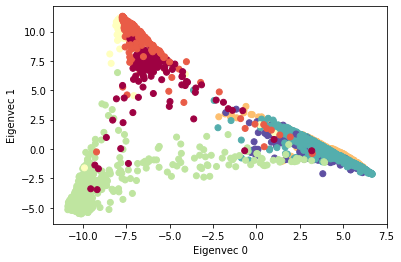

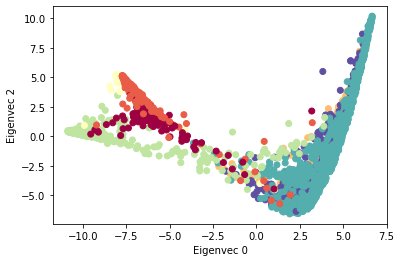

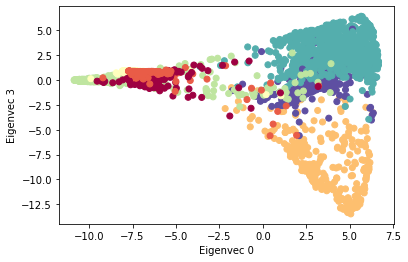

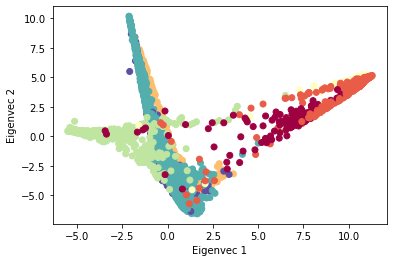

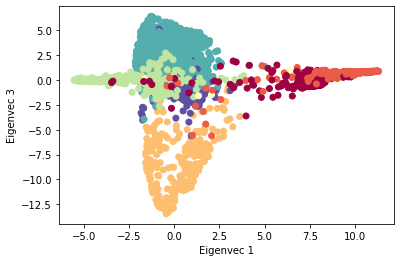

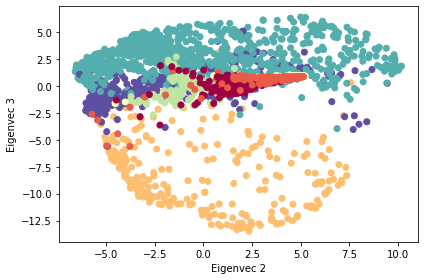

In [ ]:
runDiffMapAndPlotPairs(X, y, epsilon, k, max_plots=4, eval_models=eval_model)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X, y, epsilon, k = getZeiselData()

_, _, _, train_indices, _, test_indices = split_data_into_dataloaders(X, y, 0.8, 0) # train 80%, val 0%, test 20%

gene_features = X
gene_labels = y

# Diffusion map eval
n_evecs = len(np.unique(y))
mydmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = n_evecs, epsilon=epsilon, alpha=1, k=k)
diffusion_features = mydmap.fit_transform(X)



# misclass_rate, _, _ = new_model_metrics(
#   mydmap.dmap[train_indices, :],
#   y[train_indices],
#   mydmap.dmap[test_indices, :],
#   y[test_indices],
#   model = eval_model,
#         )

(3005, 4000)


In [ ]:
rf = RandomForestRegressor(n_estimators = 100, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, diffusion_features, test_size=0.1, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
predictions = rf.predict(X_test)
errors = abs(predictions - y_test)
# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 3), '')

Mean Absolute Error: 0.529 


In [ ]:
ind = np.argpartition(rf.feature_importances_, -500)[-500:]
max(ind)

3999

In [ ]:
X, y, epsilon, k = getZeiselData()

(3005, 4000)


In [ ]:
def compute_pushback_errors(num_index):
  
  pushback_knn_error = []
  pushback_rf_error = []
  ind = np.argpartition(rf.feature_importances_, -num_index)[-num_index:]
  new_X = X[:, ind]
  
  eval_models = [KNeighborsClassifier(), RandomForestClassifier()]
  
  for i, eval_model in enumerate(eval_models):
      print(type(eval_model))

      

      # All original features baseline
      baseline_misclass, _, _ = new_model_metrics(
          new_X[train_indices, :],
          y[train_indices],
          new_X[test_indices, :],
          y[test_indices],
          model = eval_model,
      )
      print('Baseline: ', baseline_misclass)
      if i==0:
        pushback_knn_error.append(baseline_misclass)
      else:
        pushback_rf_error.append(baseline_misclass)

  return np.array(pushback_knn_error), np.array(pushback_rf_error)
      

In [ ]:
knn_errs = []
rf_errs = []

for i in range(12, 62, 2):
  a, b = compute_pushback_errors(i)
  knn_errs.append(a)
  rf_errs.append(b)

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.11647254575707155
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.1031613976705491
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.09484193011647257
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.08319467554076543
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.09151414309484196
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.07321131447587359
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.09484193011647257
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.07986688851913482
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.08985024958402665
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.06988352745424298
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  

In [ ]:
knn_errs = np.array(knn_errs)
rf_errs = np.array(rf_errs)
np.save('knn_errs', knn_errs)
np.save('rf_errs', rf_errs)

In [ ]:
knn_errs = np.load('knn_errs.npy')
rf_errs = np.load('rf_errs.npy')

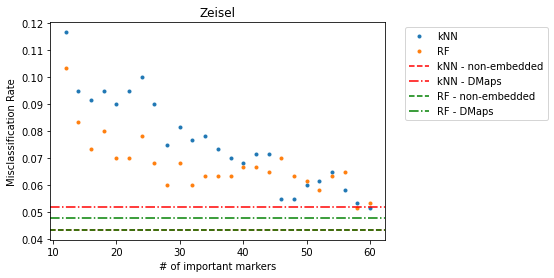

In [ ]:
plt.plot(range(12, 62, 2), knn_errs, '.', label='kNN')
plt.plot(range(12, 62, 2), rf_errs, '.', label='RF')
plt.legend()
plt.xlabel('# of important markers')
plt.ylabel('Misclassification Rate')
plt.title('Zeisel')

plt.axhline(y=0.04343, color='r', linestyle='--', label='kNN - non-embedded')
plt.axhline(y=0.05208, color='r', linestyle='-.', label='kNN - DMaps')
plt.axhline(y=0.04343, color='g', linestyle='--', label='RF - non-embedded')
plt.axhline(y=0.04775, color='g', linestyle='-.', label='RF - DMaps')
plt.legend(bbox_to_anchor=(1.5, 1))
plt.savefig('Zeisel_Pushback_Results', bbox_inches='tight')

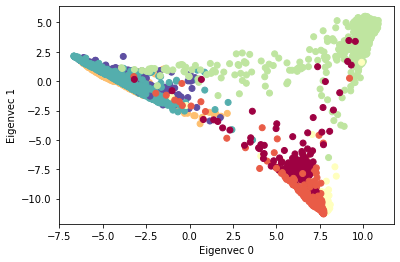

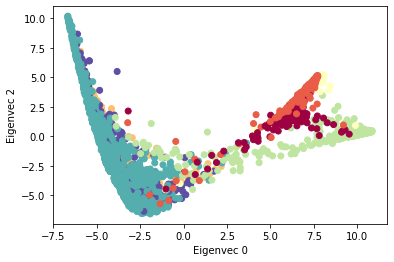

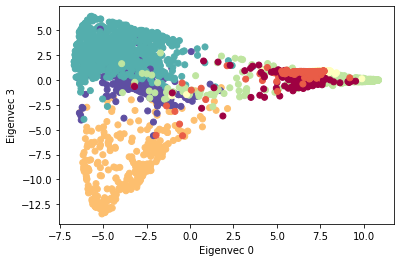

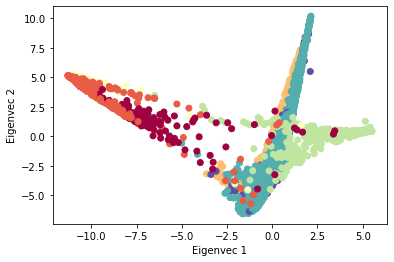

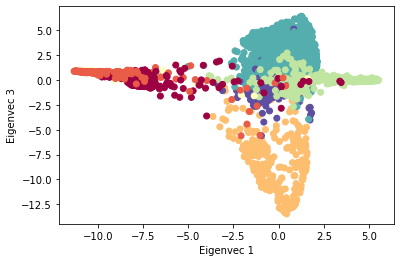

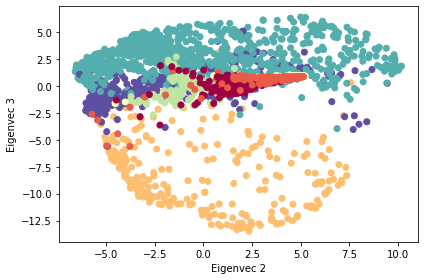

In [ ]:
plot2d(mydmap.dmap, n_cols=np.min([n_evecs, 4]), colors=y, show=True)

In [ ]:
##########################################
# baseline performance on random markers
##########################################

import random

for i in range(12, 62, 2):
  
  
  rip_knn = []
  rip_rf = []
  
  for l in range(10):
    random_indexes = random.sample(range(0, 500), i)
    new_X = X[:, random_indexes]

    pushback_knn_error = []
    pushback_rf_error = []

    eval_models = [KNeighborsClassifier(), RandomForestClassifier()]

    for j, eval_model in enumerate(eval_models):
      print(type(eval_model))


      # All original features baseline
      baseline_misclass, _, _ = new_model_metrics(
          new_X[train_indices, :],
          y[train_indices],
          new_X[test_indices, :],
          y[test_indices],
          model = eval_model,
      )
      print('Baseline: ', baseline_misclass)
      if i==0:
        pushback_knn_error.append(baseline_misclass)
      else:
        pushback_rf_error.append(baseline_misclass)
      
    rip_knn.append(np.mean(pushback_knn_error))
    rip_rf.append(np.mean(pushback_rf_error))

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.31050493325594897
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.257109692396982
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.31804991294254203
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.26001160766105624
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.30412071967498544
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.26001160766105624
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.3157283807312826
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.2565293093441672
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.40452698781195584
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.33255948926291357
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.3076030179918746
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.240858966918166
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.3012188044109112
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.24782356355194424
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.39233894370284383
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.3168891468369124
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.35461404526987816
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.2727800348229832
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.32037144515380156
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.248984329657574
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21590249564712716
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1828206616366802
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.20777713290771904
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15902495647127102
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.3395240858966918
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.26233313987231577
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.3087637840975044
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.2391178177597214
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.21242019733023798
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1729541497388276
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.31398723157283803
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.2472431804991294
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.20719674985490422
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1607661056297156
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.3087637840975044
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.24840394660475917
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.29425420777713296
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.23331398723157282
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.1828206616366802
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1526407428903076
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.28380731282646543
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.2188044109112014
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2716192687173534
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.20313406848520021
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.3110853163087638
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.24434126523505517
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2507254788160186
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.19965177016831104
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.32849680789320956
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.248984329657574
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2565293093441672
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.21125943122460822
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2988972721996518
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.22925130586186881
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2130005803830528
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.17005223447475337
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1845618107951248
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.14741729541497384
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.35635519442832264
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.26523505513639
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2826465467208358
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.23621590249564717
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.261172373766686
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1990713871154962
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2704585026117238
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.21242019733023798
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.23621590249564717
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1729541497388276
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.3255948926291352
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.232733604178758
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.3377829367382472
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.2594312246082414
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.25594892629135224
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.20777713290771904
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.15380150899593736
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.114335461404527
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1926871735345328
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1363900174114916
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.29193267556587343
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.23041207196749858
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.24608241439349976
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.19384793964016256
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.17353453279164244
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.130586186883343
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.30992455020313403
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.2170632617527568
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2629135229251306
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.19384793964016256
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1926871735345328
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.16018572257690078
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.2524666279744632
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.18398142774230997
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2988972721996518
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.22809053975623916
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.326755658734765
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.2513058618688334
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.24782356355194424
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.19210679048171797
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.232733604178758
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.20603598374927456
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.3650609402205456
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.28032501450957636
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2629135229251306
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1950087057457922
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.20023215322112597
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16598955310504937
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16424840394660478
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.126523505513639
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.20139291932675563
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.17179338363319796
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.21242019733023798
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1607661056297156
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2089378990133488
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16424840394660478
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2988972721996518
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.23215322112594317
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.20951828206616363
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.17527568195008703
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.3279164248403946
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.253047011027278
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.19616947185142197
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15960533952408584
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.14973882762623336
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1125943122460824
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.22170632617527564
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16424840394660478
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2251886244921648
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1729541497388276
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.17817759721416138
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1584445734184562
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.22925130586186881
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.17991874637260596
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.22809053975623916
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.17817759721416138
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.17237376668601279
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.130586186883343
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1990713871154962
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13406848520023218
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2809053975623912
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.20429483459082998
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19326755658734762
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.1567034242600116
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.19326755658734762
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13987231572838077
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.17527568195008703
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.138711549622751
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.20313406848520021
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16366802089378996
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.248984329657574
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.20313406848520021
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.23563551944283223
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.1665699361578642
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.23331398723157282
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.18630295995356938
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.3070226349390598
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.24260011607661058
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21416134648868257
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13929193267556583
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.22402785838653516
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16947185142193844
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21009866511897857
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.17585606500290196
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.22983168891468364
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.17411491584445737
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.1746952988972722
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14741729541497384
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21125943122460822
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.17817759721416138
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19442832269297738
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.15728380731282643
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.22402785838653516
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15612304120719678
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21938479396401622
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15612304120719678
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1828206616366802
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12768427161926876
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2147417295414974
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15380150899593736
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.21822402785838657
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1543818920487522
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2089378990133488
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.13987231572838077
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.23737666860127682
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.18514219384793962
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.1950087057457922
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1648287869994196
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.24782356355194424
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.18398142774230997
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.25594892629135224
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16715031921067902
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19558908879860704
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1363900174114916
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.14335461404526983
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.09402205455600698
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.228670922809054
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16598955310504937
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2791642484039466
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.21358096343586763
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2727800348229832
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1967498549042368
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.15206035983749278
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12013929193267558
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.18224027858386538
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.138711549622751
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.24143934997098082
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.18630295995356938
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.1404526987811956
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.09170052234474757
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21996517701683116
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15728380731282643
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.17237376668601279
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.138711549622751
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2513058618688334
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.17353453279164244
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2251886244921648
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13929193267556583
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.18572257690075444
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11781775972141617
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.22809053975623916
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.18920487521764362
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21938479396401622
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16831108531630878
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1990713871154962
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14393499709808477
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21242019733023798
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16366802089378996
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.240858966918166
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.16715031921067902
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.1688914683691236
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14799767846778877
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.17237376668601279
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14567614625652936
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.17991874637260596
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14161346488682536
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.20951828206616363
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1485780615206036
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.15147997678467784
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12536273940800924
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2547881601857226
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.18920487521764362
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19558908879860704
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12884503772489841
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2228670922809054
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16540917005223443
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.21183981427742304
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15496227510156702
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.23853743470690658
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1543818920487522
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.26233313987231577
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.2008125362739408
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1950087057457922
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11027278003482299
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.14625652930934419
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.0922809053975624
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.20197330237957056
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12536273940800924
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.21532211259431222
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14625652930934419
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.20139291932675563
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.14799767846778877
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16192687173534537
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12710388856645383
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.1926871735345328
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15496227510156702
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21764364480557163
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1584445734184562
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21125943122460822
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15147997678467784
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19558908879860704
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.118398142774231
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.21125943122460822
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14625652930934419
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2251886244921648
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1567034242600116
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1950087057457922
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.122460824143935
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16424840394660478
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11491584445734182
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.18514219384793962
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13697040046430642
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19152640742890303
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12594312246082418
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1526407428903076
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.130586186883343
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.22460824143935
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16192687173534537
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.26581543818920483
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.17933836331979103
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.17991874637260596
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.138711549622751
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2228670922809054
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.17411491584445737
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1706326175275682
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11491584445734182
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19442832269297738
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.134648868253047
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1787579802669762
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11897852582704582
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1950087057457922
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14973882762623336
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.16947185142193844
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13580963435867677
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.15554265815438184
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.09518282066163664
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1607661056297156
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11549622751015676
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.2008125362739408
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14799767846778877
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.17121300058038302
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13174695298897277
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1770168311085316
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13580963435867677
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.13697040046430642
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.0882182240278584
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1984910040626814
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.1607661056297156
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15554265815438184
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.118398142774231
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1665699361578642
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11375507835171217
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.15147997678467784
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.10388856645385958
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.15322112594312243
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11317469529889723
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.20139291932675563
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11607661056297158
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19326755658734762
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.138711549622751
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.14915844457341842
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.08299477655252463
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2228670922809054
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14915844457341842
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.17585606500290196
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.146836912362159
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.142774230992455
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.09750435287289616
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14799767846778877
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11665699361578641
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19733023795705162
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15496227510156702
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.14335461404526983
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11607661056297158
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19152640742890303
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11085316308763782
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16308763784097502
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.08937899013348816
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.18514219384793962
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1567034242600116
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.20197330237957056
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13116656993615783
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.18224027858386538
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12942542077771324
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1688914683691236
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13755078351712136
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1950087057457922
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.10795124782356358
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21416134648868257
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1567034242600116
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.13174695298897277
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.10969239698200817
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.1607661056297156
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.134648868253047
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.20023215322112597
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1363900174114916
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.15728380731282643
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.114335461404527
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1607661056297156
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11491584445734182
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16192687173534537
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.12420197330237959
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15960533952408584
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.122460824143935
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.1787579802669762
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14103308183401042
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.21416134648868257
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1665699361578642
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.20545560069645963
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.142774230992455
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.13116656993615783
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.08415554265815439
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.1787579802669762
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12942542077771324
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16773070226349396
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11491584445734182
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.21532211259431222
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.142774230992455
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1770168311085316
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1282646546720836
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.13987231572838077
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.09692396982008122
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16947185142193844
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12594312246082418
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.21242019733023798
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1282646546720836
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16018572257690078
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.1085316308763784
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.20777713290771904
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.142774230992455
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.21416134648868257
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15786419036564137
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2089378990133488
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.15554265815438184
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2431804991294254
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16540917005223443
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1648287869994196
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11375507835171217
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16366802089378996
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.11607661056297158
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.22576900754497964
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13987231572838077
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.21358096343586763
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13580963435867677
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19733023795705162
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1445153801508996
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.20545560069645963
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13580963435867677
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.19210679048171797
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12942542077771324
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.18514219384793962
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12478235635519441
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16308763784097502
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11955890887986076
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1926871735345328
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13406848520023218
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19326755658734762
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12942542077771324
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.13987231572838077
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.09402205455600698
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1404526987811956
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.10504933255948923
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16366802089378996
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.10098665118978523
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19616947185142197
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14567614625652936
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1770168311085316
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12710388856645383
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.22983168891468364
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.14799767846778877
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.16308763784097502
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13116656993615783
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.2211259431224608
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.15206035983749278
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11955890887986076
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.09692396982008122
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.19558908879860704
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14799767846778877
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.18978525827045856
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12710388856645383
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1363900174114916
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.09286128845037722
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16424840394660478
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12071967498549041
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1543818920487522
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11201392919326758
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.14741729541497384
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.09808473592571099
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.23215322112594317
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1625072547881602
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Baseline:  0.15960533952408584
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12013929193267558
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1688914683691236
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.12536273940800924
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.2048752176436448
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.130586186883343
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.22460824143935
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.13929193267556583
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.14103308183401042
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11549622751015676
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.17005223447475337
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.142774230992455
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.20835751596053398
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14799767846778877
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.18572257690075444
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.122460824143935
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.15554265815438184
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.09982588508415557
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.15206035983749278
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.122460824143935
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1706326175275682
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11317469529889723
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.15554265815438184
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11549622751015676
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.15206035983749278
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12071967498549041
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.13697040046430642
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.0882182240278584
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.16540917005223443
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.10911201392919323
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.12362159024956476
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.0824143934997098
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.12768427161926876
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.11143354614045264
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.19210679048171797
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.13929193267556583
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>


Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.19733023795705162
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.14741729541497384
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.1485780615206036
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars


Baseline:  0.1085316308763784
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Baseline:  0.12536273940800924
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Baseline:  0.08531630876378404


Mean of empty slice.
invalid value encountered in double_scalars


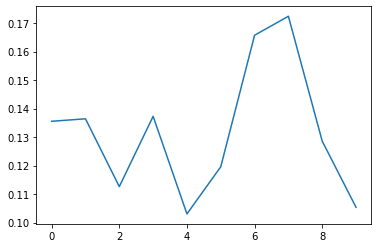

In [ ]:
plt.plot(rip_rf)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]